# Modelling product affordability

_________________________________________________________________________________

**Reference file:**
- pre_modelling_df.json: cleaned dataset before train-test split

_____________________

**Problem: Predicting product affordability**

*Target variable - afforability bins (quantiles)*

- What are the most important determinants in product pricing? Are there levers for pricing power that a company can or has leveraged on? 
    - How much weight does branding play in pricing? Do some brands have more consistent pricing over others? 
    - How are awards and publishing of clinical results related to higher prices? 
- Can the model reveal some patterns on how the industry prices its products?  
- Using market pricing trends, which products are underpriced or overpriced?
- Are there specific ingredients that potentially drive up price? 


__________________________________________________________________________________

## 1.0 Loading file

In [1]:
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import datetime
import pydotplus
import lightgbm
import re

In [33]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, f1_score, auc, precision_score, log_loss, roc_curve
from sklearn.metrics import log_loss, matthews_corrcoef

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from bayes_opt import BayesianOptimization
from catboost import CatBoostClassifier, cv, Pool
from sklearn import svm
from sklearn.pipeline import make_pipeline

In [8]:
from io import StringIO  
from IPython.display import Image  
from sklearn import tree, metrics
from matplotlib import pyplot

In [9]:
with open('../data/processed_data/pre_modelling_df.json', 'r') as file:
    data= json.load(file)
df=pd.DataFrame.from_dict(data)

In [10]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## 2.0 Train-test split

In [11]:
targeted_var = 'affordability'
excluded_features = ['product_name', 
                    #y values 
                     'pricepervol', 'affordability', 'affordability_bins',
                     'highlighted_ingr', 'ingr_list'
                    ]

In [12]:
X= df.drop(columns=excluded_features)
y= df[targeted_var]

In [13]:
y = y.astype('category')

In [14]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size= 0.3, random_state=12,
                                        #stratify= y
                                         )

In [15]:
X_tr.shape, X_te.shape

((936, 175), (402, 175))

## 3.0 Feature engineering

In [16]:
#Create a copy of datasets
X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()

In [17]:
#Scale selected columns
scaler= StandardScaler()
X_tr_scaled[['num_likes', 'num_reviews']] = scaler.fit_transform(X_tr_scaled[['num_likes', 'num_reviews']])
X_te_scaled[['num_likes', 'num_reviews']]=  scaler.transform(X_te_scaled[['num_likes', 'num_reviews']])

## 4.0 Modelling

>> METRICS TO EVALUATE FINAL - incl. matthew's corr coef (takes into account all 4 categories)
> precision_score(y_te, y_te_pred, average='weighted')


In [94]:
scores_list= ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted'
             #,'f1_micro', 'precision_micro' #removed as not imbalanced
             ]

In [109]:
#Initiating empty dictionary to store model performance
cv_records={
    'Description': [],
    'Accuracy (test) mean': [],
    'Accuracy (test) std': [],
    'Accuracy (train) mean': [],
    'Accuracy (train) std': [],
    'Recall mean': [],
    'Recall std': [],
    'Precision (weighted) mean': [],
    'Precision (weighted) std': [],
    'F1 (weighted) mean': [],
    'F1 (weighted) std': []}

In [106]:
#Creating a function to fetch CV scores for various models
def eval_model(fitted_model, X_train, y_train, num_cv=5, scores= scores_list, title='Model evaluation', show_train_scores=False):
    '''
    Uses cross-validation and returns a report of model performance metrics
    '''
    cv_results= cross_validate(fitted_model, X_train, y_train, cv=num_cv, scoring = scores, return_train_score=True)
    print(title)
    
    print('\nTest scores: (mean, SD)')
    for i in list(map(str, scores)):
        metric = 'test_'+i
        print(f' {str(i).title()}: \n ({round(cv_results[str(metric)].mean(),4)}, {round(cv_results[str(metric)].std(),4)})')
        
    if show_train_scores:
        print('\nTraining scores:')
        for i in list(map(str, scores)):
            metric = 'train_'+i
            print(f' {str(i).title()}: \n ({round(cv_results[str(metric)].mean(),4)}, {round(cv_results[str(metric)].std(),4)})')    
    else:
        pass 
    
    cv_records['Description'].append(title)
    cv_records['Accuracy (test) mean'].append(cv_results['test_accuracy'].mean())
    cv_records['Accuracy (test) std'].append(cv_results['test_accuracy'].std())
    cv_records['Accuracy (train) mean'].append(cv_results['train_accuracy'].mean())
    cv_records['Accuracy (train) std'].append(cv_results['train_accuracy'].std())
    cv_records['Recall mean'].append(cv_results['test_recall_weighted'].mean())
    cv_records['Recall std'].append(cv_results['test_recall_weighted'].std())
    cv_records['Precision (weighted) mean'].append(cv_results['test_precision_weighted'].mean())
    cv_records['Precision (weighted) std'].append(cv_results['test_precision_weighted'].std())
    cv_records['F1 (weighted) mean'].append(cv_results['test_f1_weighted'].mean())
    cv_records['F1 (weighted) std'].append(cv_results['test_f1_weighted'].std())

In [125]:
#Creating a function to show ROC for various classes
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    '''
    Returns a dictionary showing ROC-AUC score per class
    '''
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    scores=[]
    for per_class in unique_class:
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        scores.append(roc_auc)
        roc_auc_dict[per_class] = round(roc_auc,4)

    print(f'Average ROC AUC score: {round(np.mean(scores),4)}')
    return roc_auc_dict

In [98]:
def plot_cm(fitted_model, X_test, y_test):
    '''
    Prints both normalized and non-normalized confusion matrix
    '''
    np.set_printoptions(precision=2)
    titles_options = [("Confusion matrix, without normalization:", None),
                              ("Normalized confusion matrix:", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(fitted_model, X_test, y_test,
                                     display_labels=['0','1','2','3'], #used € since $ won't work
                                             cmap=plt.cm.Blues,
                                             normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

## 4.1 Classifiers

### Logistic Regression

#### I. Create base model for logistic regression

In [142]:
#Building base logistic regression model 
logreg= LogisticRegression(solver='saga', random_state=123, max_iter=1000) 

In [143]:
logreg.fit(X_tr_scaled, y_tr)
y_tr_pred = logreg.predict(X_tr_scaled)
y_te_pred = logreg.predict(X_te_scaled)

In [110]:
#Cross validated score
eval_model(logreg, X_tr_scaled, y_tr, 5, scores_list, 'LR - scaled training set, base (saga)', True)

LR - scaled training set, base (saga)

Test scores: (mean, SD)
 Accuracy: 
 (0.6303, 0.0415)
 F1_Weighted: 
 (0.6265, 0.0436)
 Precision_Weighted: 
 (0.6254, 0.0453)
 Recall_Weighted: 
 (0.6303, 0.0415)

Training scores:
 Accuracy: 
 (0.7853, 0.0096)
 F1_Weighted: 
 (0.7845, 0.0098)
 Precision_Weighted: 
 (0.7843, 0.0101)
 Recall_Weighted: 
 (0.7853, 0.0096)


In [144]:
#Performance on test set 
print('Accuracy score on test:', accuracy_score(y_te, y_te_pred), ' (not cross-validated)')
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_te, y_te_pred)
print(lr_roc_auc_multiclass)
print('Classification report: \n', classification_report(y_te, y_te_pred))

Accuracy score on test: 0.6318407960199005  (not cross-validated)
Average ROC AUC score: 0.7586
{'$$$$': 0.8034, '$': 0.8687, '$$$': 0.6558, '$$': 0.7063}
Classification report: 
               precision    recall  f1-score   support

           $       0.77      0.82      0.79        98
          $$       0.56      0.56      0.56       103
         $$$       0.54      0.46      0.50       111
        $$$$       0.64      0.72      0.68        90

    accuracy                           0.63       402
   macro avg       0.63      0.64      0.63       402
weighted avg       0.63      0.63      0.63       402



Logistic regression model - base (saga)
Confusion matrix, without normalization:
[[80 13  5  0]
 [17 58 21  7]
 [ 5 26 51 29]
 [ 2  6 17 65]]
Normalized confusion matrix:
[[0.82 0.13 0.05 0.  ]
 [0.17 0.56 0.2  0.07]
 [0.05 0.23 0.46 0.26]
 [0.02 0.07 0.19 0.72]]


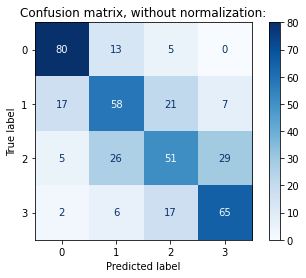

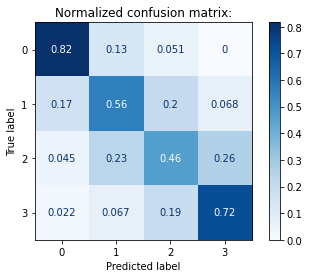

In [24]:
#Performance on test data
plot_cm(logreg, X_te_scaled, y_te)

*The initial logistic regression model has notably a higher accuracy rate for the cheapest and the most expensive classes but less so on the mid-priced products*

#### II. Tuning the logistic regression model

In [25]:
#Use GridSearch, optimizing for best accuracy
logreg_tuned=LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'sag', 'saga'] #chose the ones which can handle multinomial loss
penalty = ['l2', 'l1', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logreg_tuned, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_tr_scaled, y_tr)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
#store best parameters
logreg_opt_parameters = grid_result.best_params_

Best: 0.643491 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.628182 (0.034865) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.625357 (0.033834) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.632449 (0.034211) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.617506 (0.034331) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'sag'}
0.616430 (0.035613) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'sag'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
0.643491 (0.030503

In [26]:
logreg_opt_parameters

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}

In [145]:
#Building another LR model using the best paramaters found 
logreg_opt = LogisticRegression(solver='newton-cg', penalty='l2', C=10)

In [146]:
logreg_opt.fit(X_tr_scaled, y_tr)
y_tr_pred = logreg_opt.predict(X_tr_scaled)
y_te_pred = logreg_opt.predict(X_te_scaled)

In [140]:
#Cross validation performance
eval_model(logreg_opt, X_tr_scaled, y_tr, 5, scores_list, 'LR - scaled training set, tuned parameters', True)

LR - scaled training set, tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6314, 0.0464)
 F1_Weighted: 
 (0.6293, 0.0464)
 Precision_Weighted: 
 (0.6292, 0.0466)
 Recall_Weighted: 
 (0.6314, 0.0464)

Training scores:
 Accuracy: 
 (0.8459, 0.0143)
 F1_Weighted: 
 (0.8457, 0.0146)
 Precision_Weighted: 
 (0.8459, 0.0148)
 Recall_Weighted: 
 (0.8459, 0.0143)


In [148]:
#Performance on test set 
print('Accuracy score on test:', accuracy_score(y_te, y_te_pred), ' (not cross-validated)')
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_te, y_te_pred)
print(lr_roc_auc_multiclass)
print('Classification report: \n', classification_report(y_te, y_te_pred))

Accuracy score on test: 0.6318407960199005  (not cross-validated)
Average ROC AUC score: 0.7588
{'$$$$': 0.8161, '$': 0.8652, '$$$': 0.6541, '$$': 0.6998}
Classification report: 
               precision    recall  f1-score   support

           $       0.77      0.81      0.79        98
          $$       0.55      0.55      0.55       103
         $$$       0.54      0.46      0.50       111
        $$$$       0.66      0.74      0.70        90

    accuracy                           0.63       402
   macro avg       0.63      0.64      0.63       402
weighted avg       0.63      0.63      0.63       402



*The performance of the tuned LR model is very close to the base LR, with negligible improvement in accuracy and precision metrics.* 

#### III. Insights from the model

*Which features are highly predictive of pricing?*

In [152]:
lg_coef = np.transpose(logreg.coef_.tolist()[0])
lg_features= pd.DataFrame(zip(X_tr_scaled.columns, lg_coef, abs(lg_coef)), columns=['features', 'coef', 'abs_value'])
lg_features = lg_features.sort_values(by='abs_value', ascending=False)

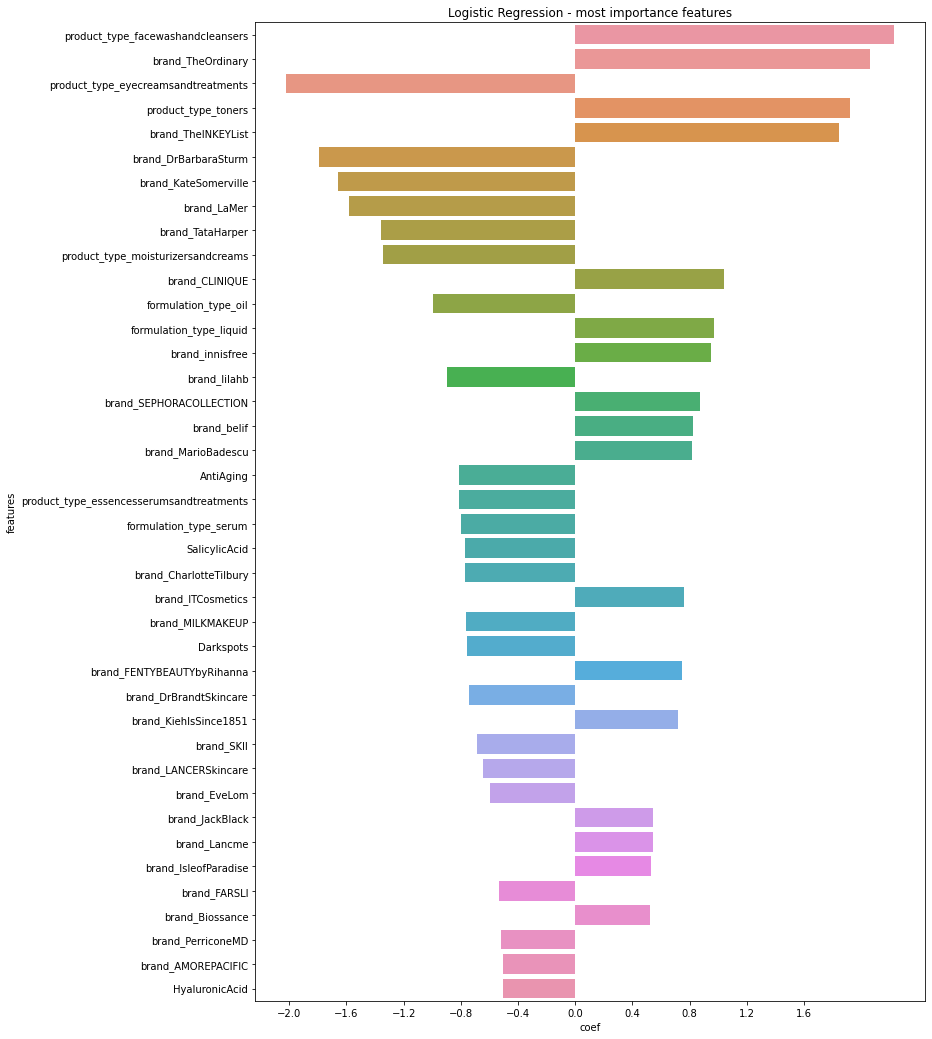

In [153]:
plt.figure(figsize=(12,18))
sns.barplot(y=lg_features.features[:40], x=lg_features.coef[:40], orient='h')
plt.title('Logistic Regression - most importance features');
plt.xticks(np.arange(-2, 2, step=0.4))
plt.show()

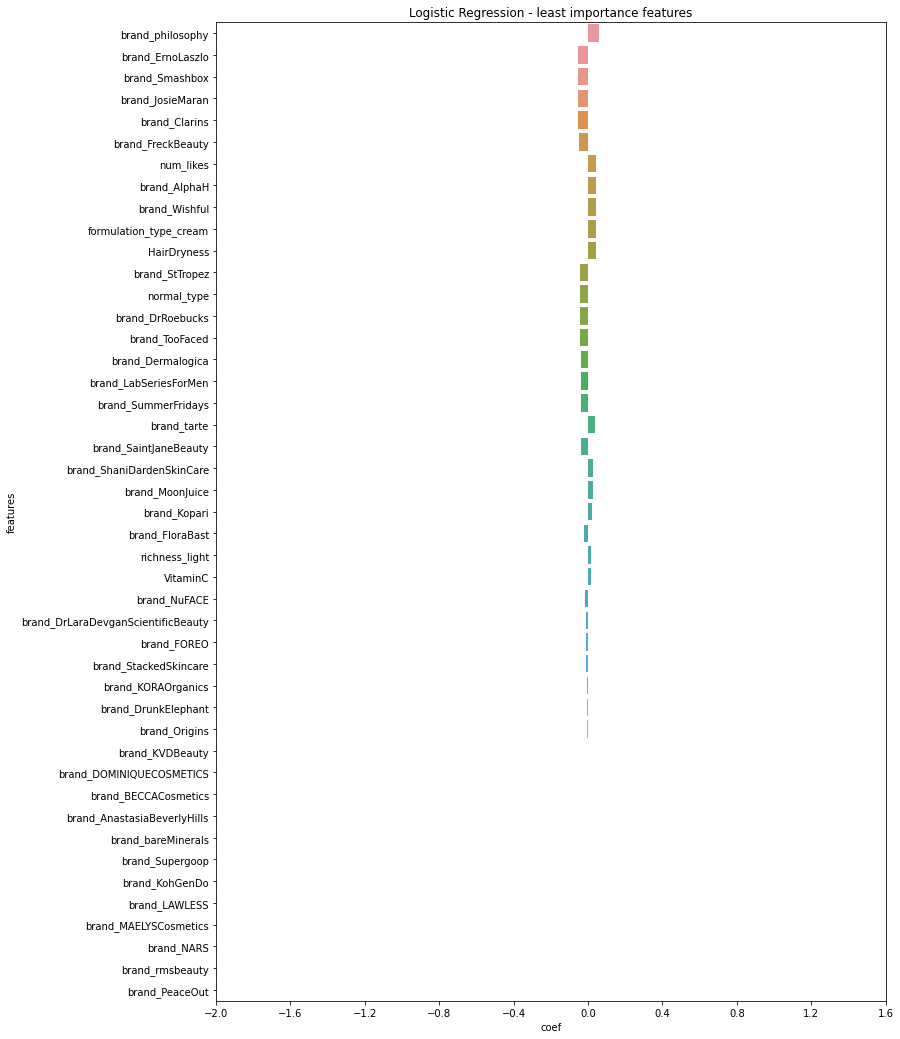

In [154]:
#Visualize
plt.figure(figsize=(12,18))
sns.barplot(y=lg_features.features[130:175], x=lg_features.coef[130:175], orient='h')
plt.title('Logistic Regression - least importance features');
plt.xticks(np.arange(-2, 2, step=0.4))
plt.show()

***Observations***

*More predictive of pricing*
- Product type: coherent with initial findings during EDA 
- Certain formulation types (i.e. - serums and oils 
- certain brands 
- specific ingredients
- specific skin concerns targeted 

*Feature that have less predictive power*
- certain brands have less sway on the product affordability
- num_likes 
- light richness
- normal type 
- cream type formulation


- Certain formulation types (i.e. - serums and oils 
- certain brands 

#### IV. Retrain the model with less features

*A. Based on logistic regression coefficients*

In [155]:
num_features= 85
selected_feat_col = lg_features[:num_features]['features'].tolist()
X_tr_select = X_tr_scaled[selected_feat_col]
X_te_select = X_te_scaled[selected_feat_col]

In [156]:
eval_model(logreg_opt, X_tr_select, y_tr, 5, scores_list, 'LR - scaled and selected training data (chosen from LR), tuned hyperparameters', True)

LR - scaled and selected training data (chosen from LR), tuned hyperparameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6528, 0.0181)
 F1_Weighted: 
 (0.6513, 0.0193)
 Precision_Weighted: 
 (0.6525, 0.0191)
 Recall_Weighted: 
 (0.6528, 0.0181)

Training scores:
 Accuracy: 
 (0.7658, 0.0034)
 F1_Weighted: 
 (0.765, 0.0041)
 Precision_Weighted: 
 (0.7654, 0.0043)
 Recall_Weighted: 
 (0.7658, 0.0034)


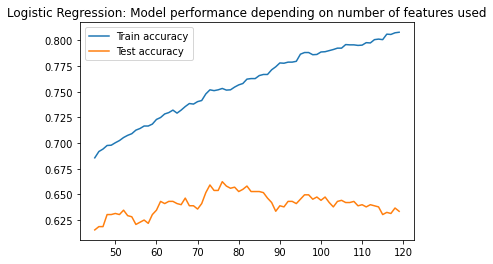

In [157]:
#Determine the optimal amount of features to use for the logistic regressino model 
min_features= 45
max_features = 120
train_accuracy = []
test_accuracy= []
counter=[]
train_accuracy_sd= []
test_accuracy_sd= []
for i in range(min_features, max_features):
    selected_feat_col = lg_features[:i]['features'].tolist()
    X_tr_select = X_tr_scaled[selected_feat_col]
    X_te_select = X_te_scaled[selected_feat_col]
    
    cv_results = cross_validate(logreg_opt, X_tr_select, y_tr, cv=5, scoring='accuracy', return_train_score= True)
    test_accuracy.append(cv_results['test_score'].mean())
    train_accuracy.append(cv_results['train_score'].mean())
    counter.append(i)
    train_accuracy_sd.append(cv_results['train_score'].std())
    test_accuracy_sd.append(cv_results['test_score'].std())
    
sns.lineplot(x=counter, y=train_accuracy, label='Train accuracy')
sns.lineplot(x=counter, y=test_accuracy, label = 'Test accuracy')
plt.title('Logistic Regression: Model performance depending on number of features used')
plt.show()

In [158]:
temp = pd.DataFrame({'num_features':counter, 'train_score': train_accuracy, 'test_score': test_accuracy})
temp[temp.test_score==temp.test_score.max()]

num_features  train_score  test_score
31            76     0.753207    0.662402

*Through feature selection, we have achieved a better model performance for logistic regression.*

In [159]:
num_chosen_features= 76
selected_feat_col = lg_features[:num_chosen_features]['features'].tolist()

Create a new training set based on features selected through logistic regression 
(which we can use to train other models)

In [164]:
X_tr_select = X_tr_scaled[selected_feat_col]
X_te_select = X_te_scaled[selected_feat_col]

In [168]:
#Build a model based on optimised LR settings and selected features
logreg_opt.fit(X_tr_select, y_tr)
y_tr_pred = logreg_opt.predict(X_tr_select)
y_te_pred = logreg_opt.predict(X_te_select)

In [160]:
#Evaluate the CV performance using selected features and optimised parameters 
eval_model(logreg_opt, X_tr_select, y_tr, 5, scores_list, 'LR - scaled and selected (chosen from LR, optimal number of features), tuned hyperparameters', True)

LR - scaled and selected (chosen from LR, optimal number of features), tuned hyperparameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6624, 0.0221)
 F1_Weighted: 
 (0.6613, 0.0233)
 Precision_Weighted: 
 (0.6626, 0.0237)
 Recall_Weighted: 
 (0.6624, 0.0221)

Training scores:
 Accuracy: 
 (0.7532, 0.004)
 F1_Weighted: 
 (0.752, 0.0038)
 Precision_Weighted: 
 (0.7524, 0.0033)
 Recall_Weighted: 
 (0.7532, 0.004)


*Based on cross-validated model performance, this model has the highest accuracy mean; however, taking into account the variability, results are not conclusive yet.*

In [169]:
#Performance on test set 
print('Accuracy score on test:', accuracy_score(y_te, y_te_pred), ' (not cross-validated)')
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_te, y_te_pred)
print(lr_roc_auc_multiclass)
print('Classification report: \n', classification_report(y_te, y_te_pred))

Accuracy score on test: 0.6293532338308457  (not cross-validated)
Average ROC AUC score: 0.757
{'$$$$': 0.8034, '$': 0.8756, '$$$': 0.6524, '$$': 0.6968}
Classification report: 
               precision    recall  f1-score   support

           $       0.76      0.84      0.80        98
          $$       0.57      0.53      0.55       103
         $$$       0.53      0.46      0.49       111
        $$$$       0.64      0.72      0.68        90

    accuracy                           0.63       402
   macro avg       0.63      0.64      0.63       402
weighted avg       0.62      0.63      0.62       402



*Using only about 43% of the total features, this model is able to achieve results comparable to the previous model (tuned parameters, full feature set).*

*B. Other feature selection methods*

Can feature selection through PCA yield better results for logistic regression?

In [161]:
pca= PCA(0.95) #retain 95% of variance
pca.fit(X_tr_scaled)

PCA(n_components=0.95)

In [162]:
pca.n_components_

66

In [163]:
#Transform both training and test set 
X_tr_pca = pca.transform(X_tr_scaled)
X_te_pca = pca.transform(X_tr_scaled)

In [172]:
eval_model(logreg, X_tr_pca, y_tr, 5, scores_list, 'LR - PCA training set, base model', True)

LR - PCA training set, base model

Test scores: (mean, SD)
 Accuracy: 
 (0.5993, 0.0351)
 F1_Weighted: 
 (0.5965, 0.0372)
 Precision_Weighted: 
 (0.597, 0.0403)
 Recall_Weighted: 
 (0.5993, 0.0351)

Training scores:
 Accuracy: 
 (0.7102, 0.0082)
 F1_Weighted: 
 (0.7095, 0.0085)
 Precision_Weighted: 
 (0.709, 0.0088)
 Recall_Weighted: 
 (0.7102, 0.0082)


In [173]:
eval_model(logreg_opt, X_tr_pca, y_tr, 5, scores_list, 'LR - PCA training set, tuned hyperparameters', True)

LR - PCA training set, tuned hyperparameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6004, 0.0372)
 F1_Weighted: 
 (0.5991, 0.0366)
 Precision_Weighted: 
 (0.6007, 0.0374)
 Recall_Weighted: 
 (0.6004, 0.0372)

Training scores:
 Accuracy: 
 (0.723, 0.0054)
 F1_Weighted: 
 (0.7232, 0.0055)
 Precision_Weighted: 
 (0.7235, 0.0057)
 Recall_Weighted: 
 (0.723, 0.0054)


_______________________________________

Plotting ROC for multilabel [https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#multiclass-settings]

____________________

### Support Vector Machines (SVM)

In [176]:
#Initiate SVM models with different kernels; used 'ovo' for multiclass strategy
linear = svm.SVC(kernel='linear', decision_function_shape='ovo')
rbf = svm.SVC(kernel='rbf', decision_function_shape='ovo')
poly = svm.SVC(kernel='poly', degree=3, decision_function_shape='ovo')
sig = svm.SVC(kernel='sigmoid', decision_function_shape='ovo')

In [177]:
linear.fit(X_tr_scaled, y_tr)
poly.fit(X_tr_scaled, y_tr)
rbf.fit(X_tr_scaled, y_tr)
sig.fit(X_tr_scaled, y_tr)
y_te_pred_lin = linear.predict(X_te_scaled)
y_te_pred_poly = poly.predict(X_te_scaled)
y_te_pred_rbf = rbf.predict(X_te_scaled)
y_te_pred_sig = sig.predict(X_te_scaled)

In [178]:
#Check initial accuracy scores on the test set 
print('Support vector machine - base')
print(f' Accuracy Linear Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_lin))
print(f' Accuracy Polynomial Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_poly))
print(f' Accuracy Radial Basis Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_rbf))
print(f' Accuracy Sigmoid Kernel: \t %.4f' % accuracy_score(y_te, y_te_pred_sig))

Support vector machine - base
 Accuracy Linear Kernel: 	 0.6443
 Accuracy Polynomial Kernel: 	 0.6318
 Accuracy Radial Basis Kernel: 	 0.6269
 Accuracy Sigmoid Kernel: 	 0.5846


*Linear kernel performs best. As the scores are not significantly different, let's check the cross-validation scores.*

In [55]:
#To evaluate with cross-validation
eval_model(linear, X_tr_scaled, y_tr, 5, scores_list, 'SVM - scaled training set, linear kernel')

SVM: Linear kernel - base

Test scores: (mean, SD)
 Accuracy: 
 (0.6314, 0.0348)
 Precision_Weighted: 
 (0.6318, 0.0374)
 Precision_Micro: 
 (0.6314, 0.0348)
 F1_Weighted: 
 (0.6301, 0.0359)
 F1_Micro: 
 (0.6314, 0.0348)


In [179]:
eval_model(poly, X_tr_scaled, y_tr, 5, scores_list, 'SVM - scaled training set, polynomial (3) kernel')

SVM - scaled training set, polynomial (3) kernel

Test scores: (mean, SD)
 Accuracy: 
 (0.5961, 0.0298)
 F1_Weighted: 
 (0.5967, 0.0314)
 Precision_Weighted: 
 (0.6055, 0.0382)
 Recall_Weighted: 
 (0.5961, 0.0298)


In [180]:
eval_model(poly, X_tr_scaled, y_tr, 5, scores_list, 'SVM - scaled training set, radial basis kernel')

SVM - scaled training set, radial basis kernel

Test scores: (mean, SD)
 Accuracy: 
 (0.5961, 0.0298)
 F1_Weighted: 
 (0.5967, 0.0314)
 Precision_Weighted: 
 (0.6055, 0.0382)
 Recall_Weighted: 
 (0.5961, 0.0298)


In [181]:
eval_model(sig, X_tr_scaled, y_tr, 5, scores_list, 'SVM - scaled training set, sigmoid kernel')

SVM - scaled training set, sigmoid kernel

Test scores: (mean, SD)
 Accuracy: 
 (0.563, 0.0313)
 F1_Weighted: 
 (0.5582, 0.0347)
 Precision_Weighted: 
 (0.5623, 0.0399)
 Recall_Weighted: 
 (0.563, 0.0313)


*With cross-validation, the gap between the model performance widens, confirming that the linear kernel SVM is superior to the others*

In [182]:
#Performance on test set 
print('Accuracy score on test:', accuracy_score(y_te, y_te_pred_lin), ' (not cross-validated)')
lr_roc_auc_multiclass = roc_auc_score_multiclass(y_te, y_te_pred_lin)
print(lr_roc_auc_multiclass)
print('Classification report: \n', classification_report(y_te, y_te_pred_lin))

Accuracy score on test: 0.6442786069651741  (not cross-validated)
Average ROC AUC score: 0.7656
{'$$$$': 0.7932, '$': 0.8738, '$$$': 0.676, '$$': 0.7195}
Classification report: 
               precision    recall  f1-score   support

           $       0.77      0.83      0.80        98
          $$       0.60      0.57      0.58       103
         $$$       0.55      0.51      0.53       111
        $$$$       0.66      0.69      0.67        90

    accuracy                           0.64       402
   macro avg       0.64      0.65      0.65       402
weighted avg       0.64      0.64      0.64       402



Confusion matrix, without normalization:
[[81 12  5  0]
 [15 59 22  7]
 [ 6 23 57 25]
 [ 3  5 20 62]]
Normalized confusion matrix:
[[0.83 0.12 0.05 0.  ]
 [0.15 0.57 0.21 0.07]
 [0.05 0.21 0.51 0.23]
 [0.03 0.06 0.22 0.69]]


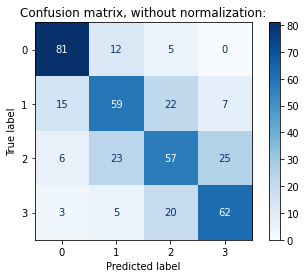

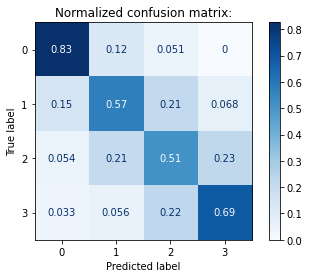

In [183]:
#Performance on test data
plot_cm(linear, X_te_scaled, y_te)

In [186]:
def f_importances(coef, col_names= X_tr.columns):
    '''
    Plot feature importances
    '''
    imp = coef
    imp,names = zip(*sorted(zip(imp,col_names.tolist())))
    plt.figure(figsize=(15,35))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [80]:
linear = svm.SVC(kernel='linear', decision_function_shape='ovo')
linear.fit(X_tr_scaled, y_tr)

SVC(decision_function_shape='ovo', kernel='linear')

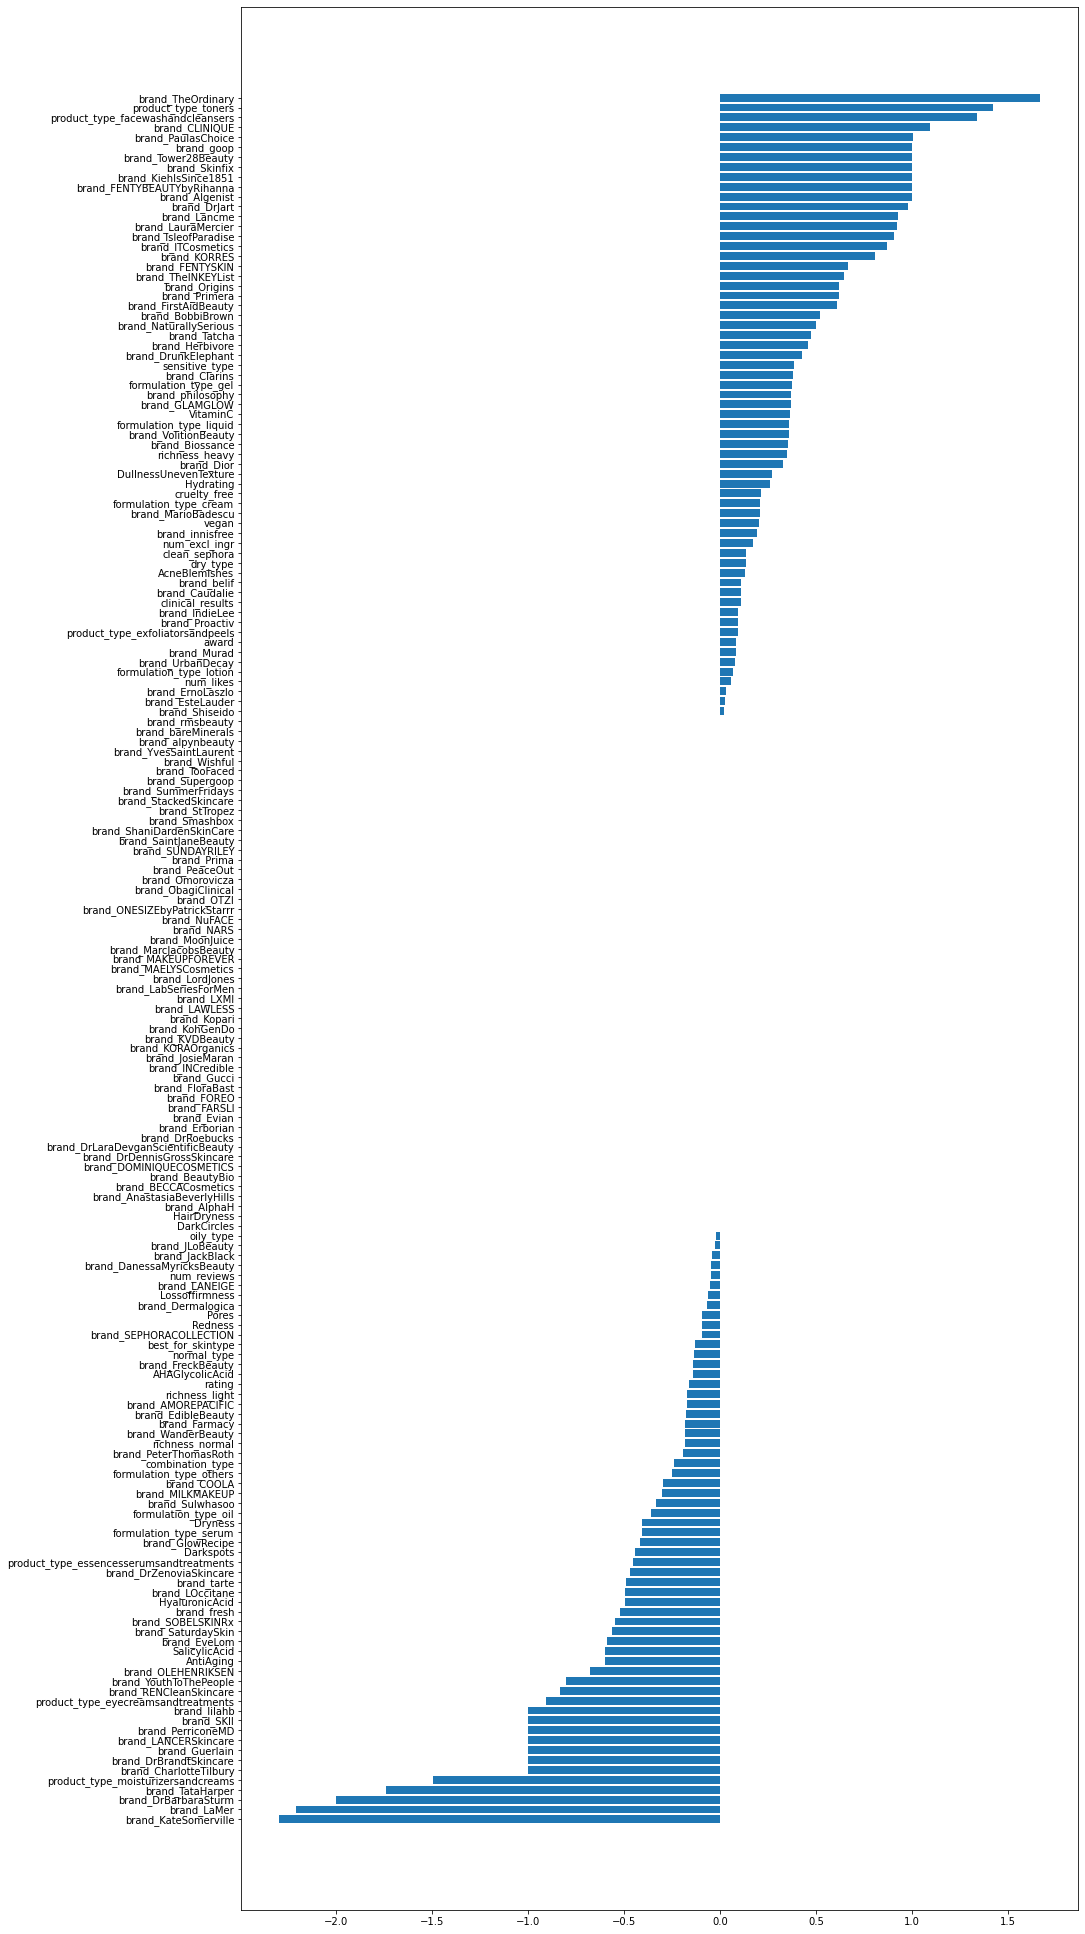

In [187]:
f_importances(linear.coef_[0], X_tr_scaled.columns)

In [197]:
temp3 = pd.DataFrame({'feature': X_tr_scaled.columns, 'coefficient': linear.coef_[0], 'abs_val': abs(linear.coef_[0])})

In [198]:
print(f'{len(temp3[temp3.abs_val==0])} features have a coefficient of 0')

52 features have a coefficient of 0


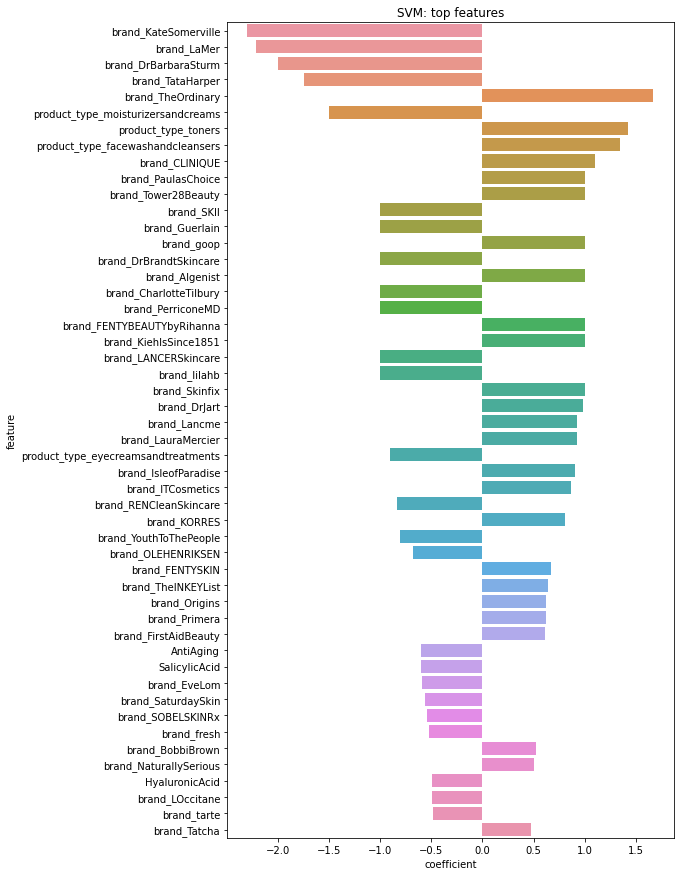

In [199]:
num_feat= 50
temp4= temp3.sort_values(by='abs_val', ascending=False)[:num_feat]
plt.figure(figsize=(8,15))
sns.barplot(data=temp4, x='coefficient' , y='feature', orient='h')
plt.title('SVM: top features')
plt.show()

#### Insights from the model: 

- Patterns in the highly and least predictive features have some overlap with what was found through logistic regression with top predictive features consisting mostly brands and product type. 
- In the SVM, 52 features had no predictive power (majority of these were also are particular brands).

> RATING TYPE ?? not predictive? 

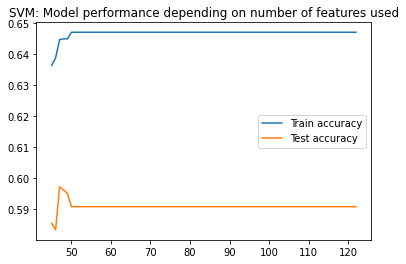

In [203]:
#Determine the optimal amount of features to use for the logistic regressino model 
min_features= 45
max_features = 123
train_accuracy = []
test_accuracy= []
counter=[]
train_accuracy_sd= []
test_accuracy_sd= []
for i in range(min_features, max_features):
    X_tr_select = X_tr_scaled[temp4[:i].feature.tolist()]
    X_te_select = X_te_scaled[temp4[:i].feature.tolist()]

    cv_results = cross_validate(linear, X_tr_select, y_tr, cv=5, scoring='accuracy', return_train_score= True)
    test_accuracy.append(cv_results['test_score'].mean())
    train_accuracy.append(cv_results['train_score'].mean())
    counter.append(i)
    train_accuracy_sd.append(cv_results['train_score'].std())
    test_accuracy_sd.append(cv_results['test_score'].std())
    
sns.lineplot(x=counter, y=train_accuracy, label='Train accuracy')
sns.lineplot(x=counter, y=test_accuracy, label = 'Test accuracy')
plt.title('SVM: Model performance depending on number of features used')
plt.show()

In [204]:
temp5 = pd.DataFrame({'num_features':counter, 'train_score': train_accuracy, 'test_score': test_accuracy})
temp5[temp5.test_score==temp5.test_score.max()]

num_features  train_score  test_score
2            47     0.644769    0.597275

Create a new training set based on feature importance found through SVM 

In [205]:
#unscaled
n= 47
X_tr_selectsvm = X_tr[temp4[:n].feature.tolist()]
X_te_selectsvm = X_te[temp4[:n].feature.tolist()]

#scaled
X_tr_sc_selectsvm = X_tr[temp4[:n].feature.tolist()]
X_te_sc_selectsvm = X_te[temp4[:n].feature.tolist()]

#### Evaluate SVM on selected features

In [206]:
#SVM based on feature selection through SVM 
eval_model(linear, X_tr_sc_selectsvm, y_tr, 5, scores_list, 'SVM - scaled training set, selected features using SVM, linear kernel', True)

SVM - scaled training set, selected features using SVM, linear kernel

Test scores: (mean, SD)
 Accuracy: 
 (0.5973, 0.0323)
 F1_Weighted: 
 (0.6048, 0.0287)
 Precision_Weighted: 
 (0.6234, 0.0241)
 Recall_Weighted: 
 (0.5973, 0.0323)

Training scores:
 Accuracy: 
 (0.6448, 0.0097)
 F1_Weighted: 
 (0.6541, 0.0096)
 Precision_Weighted: 
 (0.6731, 0.0115)
 Recall_Weighted: 
 (0.6448, 0.0097)


In [207]:
eval_model(linear, X_tr_pca, y_tr, 5, scores_list, 'SVM - PCA features, linear', True)

SVM - PCA features, linear

Test scores: (mean, SD)
 Accuracy: 
 (0.594, 0.0262)
 F1_Weighted: 
 (0.5954, 0.0292)
 Precision_Weighted: 
 (0.6019, 0.0349)
 Recall_Weighted: 
 (0.594, 0.0262)

Training scores:
 Accuracy: 
 (0.7217, 0.0059)
 F1_Weighted: 
 (0.7236, 0.006)
 Precision_Weighted: 
 (0.7269, 0.0067)
 Recall_Weighted: 
 (0.7217, 0.0059)


In [208]:
eval_model(linear, X_tr_select, y_tr, 5, scores_list,'SVM - scaled training set, selected features using LR', True)

SVM - scaled training set, selected features using LR

Test scores: (mean, SD)
 Accuracy: 
 (0.5909, 0.0269)
 F1_Weighted: 
 (0.5982, 0.0212)
 Precision_Weighted: 
 (0.6172, 0.012)
 Recall_Weighted: 
 (0.5909, 0.0269)

Training scores:
 Accuracy: 
 (0.6472, 0.0139)
 F1_Weighted: 
 (0.6559, 0.0145)
 Precision_Weighted: 
 (0.6737, 0.0186)
 Recall_Weighted: 
 (0.6472, 0.0139)


*How well will the SVM feature set do using other models?*

In [209]:
eval_model(logreg_opt, X_tr_sc_selectsvm, y_tr, 5, scores_list,'LR - SVM feature set, tuned hyperparameters')

LR - SVM feature set, tuned hyperparameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6133, 0.0184)
 F1_Weighted: 
 (0.6181, 0.0177)
 Precision_Weighted: 
 (0.6295, 0.0187)
 Recall_Weighted: 
 (0.6133, 0.0184)


## 4.2 Tree models

### Decision Tree Classifier

In [210]:
tree_criterion = 'entropy' #gini or entropy
tree_depth = None

In [211]:
dtree = DecisionTreeClassifier(criterion=tree_criterion, max_depth = tree_depth, random_state=123)
dtree.fit(X_tr_scaled, y_tr)

DecisionTreeClassifier(criterion='entropy', random_state=123)

In [212]:
y_tr_pred = dtree.predict(X_tr_scaled)
y_te_pred = dtree.predict(X_te_scaled)

In [213]:
def decision_tree(X_train, X_test, y_train, y_test, tree_criterion, tree_depth=None, disp_cm=0):
    '''
    Runs a decision tree criterion based on inputs
    Returns evaluation metrics
    '''
    dtree = DecisionTreeClassifier(criterion=tree_criterion, max_depth = tree_depth, random_state=123)
    dtree.fit(X_train, y_train)
    
    y_train_pred = dtree.predict(X_train)
    y_test_pred = dtree.predict(X_test)
    
    print(f'Decision Tree model - {tree_criterion} criterion, max depth: {tree_depth}')
    print(f'Accuracy (train): \t %.4f' %metrics.accuracy_score(y_train ,y_train_pred))
    print(f'Accuracy (test): \t %.4f' %metrics.accuracy_score(y_test ,y_test_pred))
    print(f'Balanced accuracy:\t %.4f' %metrics.balanced_accuracy_score(y_test,y_test_pred))
    print('Classification report: \n', classification_report(y_test, y_test_pred))
    
    if disp_cm>0:
        np.set_printoptions(precision=2)
        titles_options = [("Confusion matrix, without normalization:", None),
                          ("Normalized confusion matrix:", 'true')]
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(dtree, X_test, y_test,
                                             cmap=plt.cm.Blues,
                                             normalize=normalize)
            disp.ax_.set_title(title)

            print(title)
            print(disp.confusion_matrix)

        plt.show()

**Modelling without maximum tree depths**

In [214]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'entropy', None)

Decision Tree model - entropy criterion, max depth: None
Accuracy (train): 	 1.0000
Accuracy (test): 	 0.5249
Balanced accuracy:	 0.5286
Classification report: 
               precision    recall  f1-score   support

           $       0.70      0.73      0.72        98
          $$       0.40      0.34      0.37       103
         $$$       0.42      0.50      0.45       111
        $$$$       0.60      0.54      0.57        90

    accuracy                           0.52       402
   macro avg       0.53      0.53      0.53       402
weighted avg       0.52      0.52      0.52       402



In [215]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'gini', None)

Decision Tree model - gini criterion, max depth: None
Accuracy (train): 	 1.0000
Accuracy (test): 	 0.5075
Balanced accuracy:	 0.5141
Classification report: 
               precision    recall  f1-score   support

           $       0.70      0.72      0.71        98
          $$       0.38      0.46      0.41       103
         $$$       0.40      0.34      0.37       111
        $$$$       0.61      0.53      0.57        90

    accuracy                           0.51       402
   macro avg       0.52      0.51      0.51       402
weighted avg       0.51      0.51      0.51       402



*Observations:*
- Entropy model performs slightly better than using the gini coefficient as criterion for the decision tree model.
- In both models: 
    - Without a limit on the tree depth, the model overfits entirely, as expected.
    - Better prediction for the cheapest and most expensive segments (0, 3).

**Modelling with limitation on tree depth**

In order to avoid overfitting and improve generalisability of the model, we will impose a max depth on the trees built.

In [216]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'entropy', 10)

Decision Tree model - entropy criterion, max depth: 10
Accuracy (train): 	 0.6987
Accuracy (test): 	 0.5622
Balanced accuracy:	 0.5626
Classification report: 
               precision    recall  f1-score   support

           $       0.82      0.72      0.77        98
          $$       0.47      0.34      0.40       103
         $$$       0.41      0.63      0.50       111
        $$$$       0.69      0.56      0.62        90

    accuracy                           0.56       402
   macro avg       0.60      0.56      0.57       402
weighted avg       0.59      0.56      0.56       402



In [217]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'gini', 10)

Decision Tree model - gini criterion, max depth: 10
Accuracy (train): 	 0.7041
Accuracy (test): 	 0.5796
Balanced accuracy:	 0.5800
Classification report: 
               precision    recall  f1-score   support

           $       0.82      0.79      0.80        98
          $$       0.49      0.42      0.45       103
         $$$       0.42      0.59      0.49       111
        $$$$       0.72      0.52      0.61        90

    accuracy                           0.58       402
   macro avg       0.61      0.58      0.59       402
weighted avg       0.61      0.58      0.58       402



*Observations*
- With the shallower tree, the accuracy on the training set decreases as expected but the generalisability (i.e. performance on unseen data / test set) improves for both models.
- We observe better predictive ability for all classes.
- Without imposing a tree depth, entropy model performed better. However, as shown above, the tree model performance varies depending on the depth used. This will be explored further.

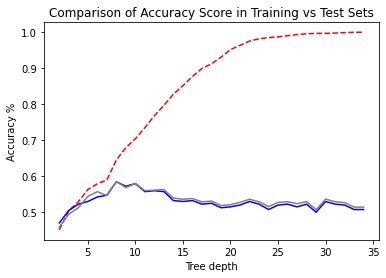

In [218]:
depths = [n for n in range(2, 35)]
training_score= []
testing_score=[]
b_testing_score=[]

for val in depths: 
    dtree = DecisionTreeClassifier(criterion='gini', max_depth = val, random_state=123)
    dtree.fit(X_tr_scaled, y_tr)
    
    y_train_pred = dtree.predict(X_tr_scaled)
    y_test_pred = dtree.predict(X_te_scaled)
    
    training_score.append(metrics.accuracy_score(y_tr ,y_train_pred))
    testing_score.append(metrics.accuracy_score(y_te ,y_test_pred))
    b_testing_score.append(metrics.balanced_accuracy_score(y_te,y_test_pred))

plt.plot(depths, training_score, linestyle='dashed', color='red')
plt.plot(depths, testing_score, linestyle='solid', color='blue')
plt.plot(depths, b_testing_score, linestyle='solid', color='grey')
plt.title('Comparison of Accuracy Score in Training vs Test Sets')
plt.xlabel('Tree depth')
plt.ylabel('Accuracy %')
plt.show()

In [219]:
decision_tree(X_tr_scaled, X_te_scaled, y_tr, y_te, 'gini', 8)

Decision Tree model - gini criterion, max depth: 8
Accuracy (train): 	 0.6453
Accuracy (test): 	 0.5846
Balanced accuracy:	 0.5850
Classification report: 
               precision    recall  f1-score   support

           $       0.88      0.77      0.82        98
          $$       0.61      0.24      0.35       103
         $$$       0.42      0.72      0.53       111
        $$$$       0.63      0.61      0.62        90

    accuracy                           0.58       402
   macro avg       0.64      0.58      0.58       402
weighted avg       0.63      0.58      0.58       402



*Observations*
- Based on the visualisation above, the better model uses a gini criterion with a max depth of 8 layers. 
- Performance-wise, however, the lift is not significant. 

In [220]:
dtree2 = DecisionTreeClassifier(criterion='gini', max_depth = 8, random_state=123)
dtree2.fit(X_tr_scaled, y_tr)

DecisionTreeClassifier(max_depth=8, random_state=123)

In [221]:
y_tr_pred = dtree.predict(X_tr_scaled)
y_te_pred = dtree.predict(X_te_scaled)

In [222]:
dot_data = StringIO()

#Create DOT data 
tree.export_graphviz(dtree2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names=X_tr_scaled.columns,
                class_names = ['£','££', '£££', '££££']
                ) 

#Draw graph
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Show graph
Image(graph.create_png())

#Save to file 
graph.write_png('decisiontree.png')

True

#### Insights from the model

- Useful features: Product type, specific brands, number of likes 
- To some extent, richness, number of reviews, DullnessUneven, clean@sephora

#### Retain the tree model using selected features

*Can we increase model performance using the feature selection from other models?*

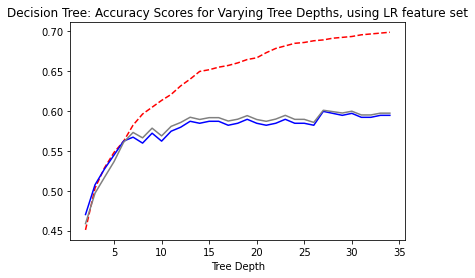

In [231]:
#Using features from logistic regression 

#Also determine the optimal depth for the tree
depths = [n for n in range(2, 35)]
training_score= []
testing_score=[]
b_testing_score=[]

for val in depths: 
    dtree = DecisionTreeClassifier(criterion='gini', max_depth = val, random_state=123)
    dtree.fit(X_tr_select, y_tr)
    
    y_train_pred = dtree.predict(X_tr_select)
    y_test_pred = dtree.predict(X_te_select)
    
    training_score.append(metrics.accuracy_score(y_tr ,y_train_pred))
    testing_score.append(metrics.accuracy_score(y_te ,y_test_pred))
    b_testing_score.append(metrics.balanced_accuracy_score(y_te,y_test_pred))

plt.plot(depths, training_score, linestyle='dashed', color='red')
plt.plot(depths, testing_score, linestyle='solid', color='blue')
plt.plot(depths, b_testing_score, linestyle='solid', color='grey')
plt.title('Decision Tree: Accuracy Scores for Varying Tree Depths, using LR feature set')
plt.xlabel('Tree Depth')
plt.show()

In [230]:
temp2 = pd.DataFrame({'depth': depths, 'training_score': training_score, 'testing_score': testing_score})
temp2[temp2.testing_score==temp2.testing_score.max()]

depth  training_score  testing_score
25     27        0.689103       0.599502

In [233]:
dtree_lgfeatures = DecisionTreeClassifier(criterion='gini', max_depth = 27, random_state=123)

In [234]:
dtree_lgfeatures.fit(X_tr_select, y_tr)
y_tr_pred = dtree_lgfeatures.predict(X_tr_select)
y_te_pred = dtree_lgfeatures.predict(X_te_select)

In [235]:
#Check accuracy 
eval_model(dtree_lgfeatures, X_tr_select, y_tr, 5, scores_list, 'DT - scaled and chosen from LR set, with max depth', True)

DT - scaled and chosen from LR set, with max depth

Test scores: (mean, SD)
 Accuracy: 
 (0.5695, 0.0277)
 F1_Weighted: 
 (0.5696, 0.0356)
 Precision_Weighted: 
 (0.5873, 0.0327)
 Recall_Weighted: 
 (0.5695, 0.0277)

Training scores:
 Accuracy: 
 (0.6942, 0.006)
 F1_Weighted: 
 (0.6988, 0.006)
 Precision_Weighted: 
 (0.7193, 0.0156)
 Recall_Weighted: 
 (0.6942, 0.006)


In [237]:
#Evaluate model
decision_tree(X_tr_select, X_te_select, y_tr, y_te, 'gini', 27)

Decision Tree model - gini criterion, max depth: 27
Accuracy (train): 	 0.6891
Accuracy (test): 	 0.5995
Balanced accuracy:	 0.6009
Classification report: 
               precision    recall  f1-score   support

           $       0.82      0.81      0.81        98
          $$       0.59      0.46      0.51       103
         $$$       0.43      0.59      0.50       111
        $$$$       0.67      0.56      0.61        90

    accuracy                           0.60       402
   macro avg       0.63      0.60      0.61       402
weighted avg       0.62      0.60      0.60       402



*Model performance has increased by 1-2%*

### RandomForest Model

In [238]:
#First try the default settings for RF
rf = RandomForestClassifier(random_state = 123, n_jobs=-1)

In [239]:
eval_model(rf, X_tr, y_tr, 5, scores_list, 'RandomForest - no max depth', True)

RandomForest - no max depth

Test scores: (mean, SD)
 Accuracy: 
 (0.6175, 0.032)
 F1_Weighted: 
 (0.6118, 0.0331)
 Precision_Weighted: 
 (0.6129, 0.0327)
 Recall_Weighted: 
 (0.6175, 0.032)

Training scores:
 Accuracy: 
 (1.0, 0.0)
 F1_Weighted: 
 (1.0, 0.0)
 Precision_Weighted: 
 (1.0, 0.0)
 Recall_Weighted: 
 (1.0, 0.0)


*Using the default parameters, it will overfit as we did not set a max depth.*

**Imposing max depth on the RandomForest Model**

In [240]:
rf_criterion='entropy' #default: gini
estimators= 100
rf_depth=6
rf2= RandomForestClassifier(n_estimators = estimators, criterion = rf_criterion,   
                            max_depth= rf_depth, random_state = 123, n_jobs=-1)

In [245]:
rf2.fit(X_tr, y_tr)
y_tr_pred= rf2.predict(X_tr)
y_te_pred= rf2.predict(X_te)

In [246]:
#Since RF is not distance based, we can try non-scaled 
eval_model(rf2, X_tr, y_tr, 5, scores_list, 'RandomForest model - max depth imposed', True)

RandomForest model - max depth imposed

Test scores: (mean, SD)
 Accuracy: 
 (0.6004, 0.0396)
 F1_Weighted: 
 (0.5902, 0.042)
 Precision_Weighted: 
 (0.5888, 0.0428)
 Recall_Weighted: 
 (0.6004, 0.0396)

Training scores:
 Accuracy: 
 (0.7676, 0.0102)
 F1_Weighted: 
 (0.7648, 0.0101)
 Precision_Weighted: 
 (0.7668, 0.0108)
 Recall_Weighted: 
 (0.7676, 0.0102)


In [247]:
print('Classification report: \n', classification_report(y_te, y_te_pred))

Classification report: 
               precision    recall  f1-score   support

           $       0.71      0.81      0.75        98
          $$       0.54      0.47      0.50       103
         $$$       0.54      0.45      0.49       111
        $$$$       0.60      0.72      0.66        90

    accuracy                           0.60       402
   macro avg       0.60      0.61      0.60       402
weighted avg       0.59      0.60      0.59       402



Confusion matrix, without normalization:
[[79 14  5  0]
 [24 48 22  9]
 [ 6 21 50 34]
 [ 3  6 16 65]]
Normalized confusion matrix:
[[0.81 0.14 0.05 0.  ]
 [0.23 0.47 0.21 0.09]
 [0.05 0.19 0.45 0.31]
 [0.03 0.07 0.18 0.72]]


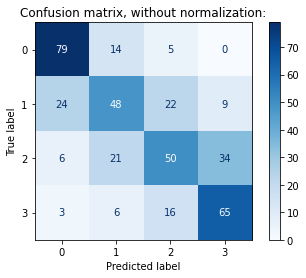

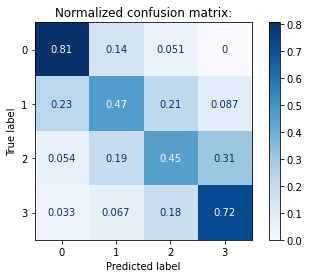

In [248]:
plot_cm(rf2, X_te, y_te)

**Visualizing the tree**

*Which feature are predictive of pricing?*

In [160]:
# estimator = rf2.estimators_[5]
# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = X_tr_scaled.columns,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

30


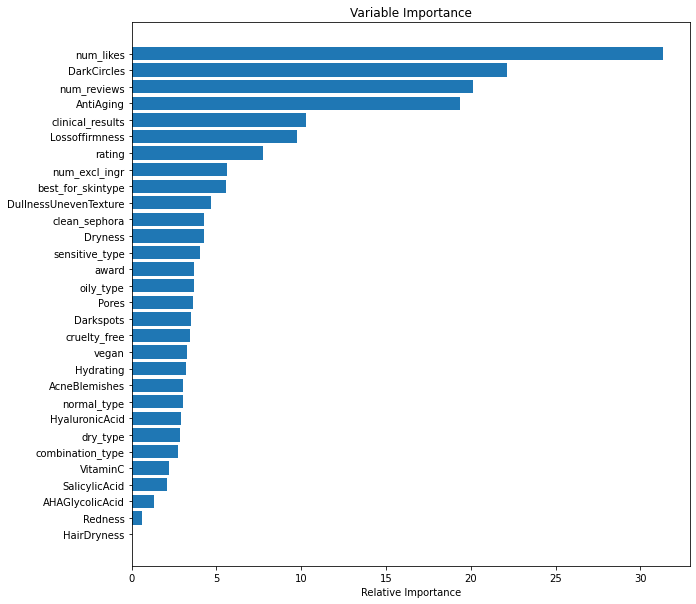

In [161]:
feature_importances = rf2.feature_importances_
# make importances relative to max importance
feature_importances = 100.0 * (feature_importances / feature_importances.max())[:30]
sorted_idx = np.argsort(feature_importances)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importances[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

<font color='red'> Note: feature importance order changed when x_tr_scaled is used </font>

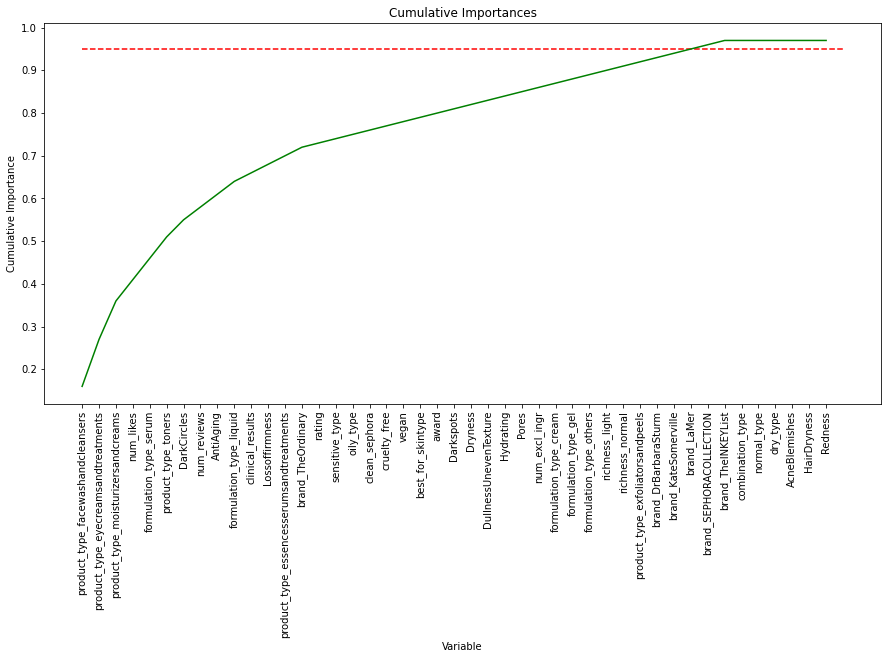

In [162]:
feat_list =[(feature, round(feature_importance, 2))
    for feature, feature_importance in zip(X_tr.columns, rf2.feature_importances_.tolist())]
feat_list = sorted(feat_list, key = lambda x:x[1], reverse=True)[:45]
x_values = list(range(45))
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feat_list]
sorted_features = [importance[0] for importance in feat_list]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.figure(figsize=(15,7))
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); 
plt.title('Cumulative Importances');
plt.show()

In [163]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feat_list[0:38]]
important_feature_names

['product_type_facewashandcleansers',
 'product_type_eyecreamsandtreatments',
 'product_type_moisturizersandcreams',
 'num_likes',
 'formulation_type_serum',
 'product_type_toners',
 'DarkCircles',
 'num_reviews',
 'AntiAging',
 'formulation_type_liquid',
 'clinical_results',
 'Lossoffirmness',
 'product_type_essencesserumsandtreatments',
 'brand_TheOrdinary',
 'rating',
 'sensitive_type',
 'oily_type',
 'clean_sephora',
 'cruelty_free',
 'vegan',
 'best_for_skintype',
 'award',
 'Darkspots',
 'Dryness',
 'DullnessUnevenTexture',
 'Hydrating',
 'Pores',
 'num_excl_ingr',
 'formulation_type_cream',
 'formulation_type_gel',
 'formulation_type_others',
 'richness_light',
 'richness_normal',
 'product_type_exfoliatorsandpeels',
 'brand_DrBarbaraSturm',
 'brand_KateSomerville',
 'brand_LaMer',
 'brand_SEPHORACOLLECTION']

*Try building out a new model based only on these features*

In [174]:
X_tr_select_rf = X_tr.loc[:, important_feature_names].copy()
X_te_select_rf = X_te.loc[:, important_feature_names].copy()

**Optimize the RandomForest model using GridSearch**

Selected parameters to tune for RF:
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

Leveraging on Bayesian Optimization

https://pierpaolo28.github.io/blog/blog25/#automated-hyperparameter-tuning

In [177]:
#! pip install hyperopt

     |████████████████████████████████| 965 kB 1.3 MB/s eta 0:00:01


In [180]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_tr, y_tr, cv = 4).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

100%|██████████| 80/80 [03:34<00:00,  2.69s/trial, best loss: -0.5673076923076923]


{'criterion': 0,
 'max_depth': 1040.0,
 'max_features': 0,
 'min_samples_leaf': 0.0014690290820691192,
 'min_samples_split': 0.242249309350692,
 'n_estimators': 3}

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 3000, num = 50)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 1100, num = 100)]
max_depth.append(None)
min_samples_split = [2, 60, 75, 90]
min_samples_leaf = [0, 1, 3, 5, 7]
#min_samples_split = [60, 75, 90]
#min_samples_leaf = [1, 3, 5, 7]
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [193]:
rf_search_bayes = RandomForestClassifier(random_state = 123, n_jobs=-1)
rf_cv= RandomizedSearchCV(rf_search_bayes, random_grid, cv=5, n_iter=5)
rf_cv.fit(X_tr,y_tr)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=-1,
                                                    random_state=123),
                   n_iter=5,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 109, 120, 131,
                                                      142, 153, 164, 175, 186,
                                                      197, 208, 219, 230, 241,
                                                      252, 263, 274, 285, 296,
                                                      307, 318, 329, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [0, 1, 3, 5, 7],
                                        'min_samples_split': [1, 60, 75, 90],
                                        'n_e

In [194]:
rf_cv.best_score_

0.5972408692684036

In [200]:
rf_cv.best_params_

{'n_estimators': 1593,
 'min_samples_split': 90,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 98,
 'bootstrap': False}

In [ ]:
{'n_estimators': 1593,
 'min_samples_split': 90,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 98,
 'bootstrap': False}

In [201]:
rf_opt_bayes= RandomForestClassifier(n_estimators=1593, min_samples_split= 90, min_samples_leaf= 1,
                               max_features='sqrt', max_depth= 98, bootstrap=False, random_state=123)

In [202]:
eval_model(rf_opt_bayes, X_tr, y_tr, 5, scores_list, 'RandomForest - search + bayesopt', True)

RandomForest - search + bayesopt

Test scores: (mean, SD)
 Accuracy: 
 (0.5972, 0.0308)
 Precision_Weighted: 
 (0.5822, 0.0327)
 Precision_Micro: 
 (0.5972, 0.0308)
 F1_Weighted: 
 (0.5839, 0.0326)
 F1_Micro: 
 (0.5972, 0.0308)

Training scores:
 Accuracy: 
 (0.7468, 0.012)
 Precision_Weighted: 
 (0.747, 0.0115)
 Precision_Micro: 
 (0.7468, 0.012)
 F1_Weighted: 
 (0.7422, 0.0127)
 F1_Micro: 
 (0.7468, 0.012)


>

## 4.3 Other

## GradientBoosting

In [243]:
param={
    'n_estimators':[50, 100, 150],
    'max_depth': [3, 7, 11, 15],
    'learning_rate':[0.01, 0.1, 1]
}

gb_gs=GridSearchCV(GradientBoostingClassifier(), param, cv=5, n_jobs=-1)
cv_fit= gb_gs.fit(X_tr, y_tr)

In [245]:
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       2.473095      0.077596         0.006779        0.001832   
13       1.820788      0.108393         0.006661        0.000489   
12       0.827434      0.018265         0.005577        0.000627   
15       1.819636      0.037662         0.007993        0.002551   
17       5.249524      0.074025         0.010198        0.002732   
19       5.778719      0.143259         0.011681        0.001525   
16       3.502796      0.031013         0.007652        0.000715   
33       3.950502      0.037696         0.008267        0.001461   
31       5.647753      0.099957         0.013124        0.006618   
34       7.581604      0.079227         0.014116        0.004970   
27       1.763050      0.038554         0.008067        0.001504   
18       3.113939      0.105510         0.009706        0.003216   
5        5.586102      0.169484         0.010545        0.002196   
23      13.506250      0.434758         0.017882        0.001285   
20       8.755913      0.149696         0.014556        0.003527   
30       2.873410      0.066203         0.008398        0.002690   
32       8.522210      0.142375         0.018654        0.004536   
35       9.709196      1.787985         0.013210        0.002431   
22       8.899584      0.367980         0.014601        0.003447   
26       2.493716      0.074662         0.009544        0.002645   
4        3.557316      0.139274         0.006728        0.000854   
28       3.499500      0.015957         0.009100        0.002114   
25       1.639022      0.040109         0.008113        0.001479   
21       4.438062      0.116323         0.011502        0.003720   
29       5.396000      0.107425         0.011084        0.001313   
8       10.209568      0.274421         0.015499        0.002008   
7        7.948169      0.637985         0.013859        0.004891   
6        3.134168      0.085720         0.008815        0.001242   
2        2.235048      0.050173         0.007751        0.001313   
24       0.815214      0.027607         0.006289        0.001347   
11      15.086894      0.616642         0.019387        0.002832   
3        1.708075      0.031704         0.005760        0.000875   
9        4.448753      0.280483         0.009817        0.002608   
10       9.764998      0.325544         0.019072        0.004712   
1        1.614338      0.076841         0.006162        0.001218   
0        0.791106      0.036713         0.005990        0.000421   

   param_learning_rate param_max_depth param_n_estimators  \
14                 0.1               3                150   
13                 0.1               3                100   
12                 0.1               3                 50   
15                 0.1               7                 50   
17                 0.1               7                150   
19                 0.1              11                100   
16                 0.1               7                100   
33                   1              15                 50   
31                   1              11                100   
34                   1              15                100   
27                   1               7                 50   
18                 0.1              11                 50   
5                 0.01               7                150   
23                 0.1              15                150   
20                 0.1              11                150   
30                   1              11                 50   
32                   1              11                150   
35                   1              15                150   
22                 0.1              15                100   
26                   1               3                150   
4                 0.01               7                100   
28                   1               7                100   
25                   1               3                100   
21                 0.1 

In [246]:
gb_opt= GradientBoostingClassifier(n_estimators=150 , max_depth= 3, learning_rate= 0.1)

In [247]:
eval_model(gb_opt, X_tr, y_tr, 5, scores_list, 'Gradient Boosting - tuned parameters', True)

Gradient Boosting - tuned parameters

Test scores: (mean, SD)
 Accuracy: 
 (0.6442, 0.0389)
 Precision_Weighted: 
 (0.6483, 0.0449)
 Precision_Micro: 
 (0.6442, 0.0389)
 F1_Weighted: 
 (0.6437, 0.0418)
 F1_Micro: 
 (0.6442, 0.0389)

Training scores:
 Accuracy: 
 (0.9201, 0.006)
 Precision_Weighted: 
 (0.9207, 0.0059)
 Precision_Micro: 
 (0.9201, 0.006)
 F1_Weighted: 
 (0.9203, 0.006)
 F1_Micro: 
 (0.9201, 0.006)


> how do we make this interpretable? 

### XGBoost

In [207]:
! pip install xgboost

     |████████████████████████████████| 1.2 MB 957 kB/s eta 0:00:01


In [211]:
! brew install libomp

Updating Homebrew...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
atuin               gcc@10              mathlibtools        scotch
cadical             gitbackup           neovim-remote       search-that-hash
clazy               ipinfo-cli          openexr@2           trojan-go
ddcctl              julia               pgxnclient          zellij
elan-init           lsix                rmw
==> Updated Formulae
Updated 674 formulae.
==> Deleted Formulae
aurora-cli          erlang@20           protobuf-swift      protobuf@3.7

==> Downloading https://ghcr.io/v2/homebrew/core/libomp/manifests/12.0.0
######################################################################## 100.0%
==> Downloading https://ghcr.io/v2/homebrew/core/libomp/blobs/sha256:e6ccdea1356
==> Downloading from https://pkg-containers.githubusercontent.com/ghcr1/blobs/sh
######################################################################## 100.0%
==> Pouring libomp--12.0.0.mojave.bottle.tar.g

In [215]:
X_tr.columns.tolist()

['num_likes',
 'rating',
 'num_reviews',
 'sensitive_type',
 'combination_type',
 'oily_type',
 'normal_type',
 'dry_type',
 'clean_sephora',
 'cruelty_free',
 'vegan',
 'best_for_skintype',
 'award',
 'clinical_results',
 'AcneBlemishes',
 'AntiAging',
 'DarkCircles',
 'Darkspots',
 'Dryness',
 'DullnessUnevenTexture',
 'HairDryness',
 'Hydrating',
 'Lossoffirmness',
 'Pores',
 'Redness',
 'num_excl_ingr',
 'AHAGlycolicAcid',
 'HyaluronicAcid',
 'SalicylicAcid',
 'VitaminC',
 'formulation_type_cream',
 'formulation_type_gel',
 'formulation_type_liquid',
 'formulation_type_lotion',
 'formulation_type_oil',
 'formulation_type_others',
 'formulation_type_serum',
 'richness_heavy',
 'richness_light',
 'richness_normal',
 'product_type_essencesserumsandtreatments',
 'product_type_exfoliatorsandpeels',
 'product_type_eyecreamsandtreatments',
 'product_type_facewashandcleansers',
 'product_type_moisturizersandcreams',
 'product_type_toners',
 'brand_AMOREPACIFIC',
 'brand_Algenist',
 'brand_

In [217]:
D_train = xgb.DMatrix(X_tr, label)
D_test = xgb.DMatrix(X_te)

In [ ]:
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 3} 

steps = 20  # The number of training iterations

In [ ]:
model = xgb.train(param, D_train, steps)

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))

In [250]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = RandomizedSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=5)

grid.fit(X_tr_scaled, y_tr)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:53:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           

In [251]:
grid.best_score_, grid.best_params_

(-0.9133281166551239,
 {'min_child_weight': 1,
  'max_depth': 4,
  'gamma': 0.1,
  'eta': 0.15,
  'colsample_bytree': 0.5})

In [253]:
xgb_opt = xgb.XGBClassifier(min_child_weight= 1, max_depth= 4, gamma= 0.1, eta= 0.15, colsample_bytree= 0.5)

In [255]:
eval_model(xgb_opt, X_tr_scaled, y_tr, 5, scores_list, 'XGBoost - tuned parameters', True)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:57:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:57:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:57:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:57:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

In [257]:
from sklearn.model_selection import GridSearchCV

clf = xgb.XGBClassifier()
parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = RandomizedSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=5)

grid.fit(X_tr, y_tr)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:03:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params'

In [258]:
print(grid.best_params_)

{'min_child_weight': 1, 'max_depth': 6, 'gamma': 0.2, 'eta': 0.1, 'colsample_bytree': 0.7}


In [260]:
xgb_opt2 = xgb.XGBClassifier(min_child_weight= 1, max_depth= 6, gamma= 0.2, eta= 0.1, colsample_bytree= 0.7)

In [261]:
eval_model(xgb_opt2, X_tr, y_tr, 5, scores_list, 'XGBoost - tuned parameters, unscaled training set', True)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:04:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:04:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:04:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the object

In [262]:
xgb_opt2.fit(X_tr, y_tr)
y_te_pred = xgb_opt2.predict(X_te)

[22:05:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [264]:
accuracy_score(y_te, y_te_pred)

0.5920398009950248

In [ ]:
model.dump_model('dump.raw.txt')